In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import anndata
import pandas as pd
import tools
import logging
from annotation import datasets
import tools
import matplotlib.pyplot as plt


Global seed set to 0


In [2]:
## loading the model
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))


HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum())

n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [3]:
adata_mvi.obs

,celltype,batch_id,modality,latent_time,_scvi_batch,_scvi_labels
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired,0.604954,0,0
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired,0.281341,0,0
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired,0.851495,0,0
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired,0.982605,0,0
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired,0.549869,0,0
...,...,...,...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired,0.454965,0,0
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired,0.598991,0,0
TTTGTGTTCAATGACC-1_paired,IPC,1,paired,0.291581,0,0
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired,0.776289,0,0


In [5]:
model = model.load("model_neural_BM_mouse_causal_002_3", adata_mvi)

INFO     File model_neural_BM_mouse_causal_002_3/model.pt already downloaded                 
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [7]:
import matplotlib.pyplot as plt

# loadmatrix = model.get_atac_loading()
import seaborn as sns
# plt.figure(figsize=(25,4))
# hm = sns.heatmap(loadmatrix.T)
# hm.set(xticklabels=[]) 
# hm.set(xlabel="Peaks") 

[Text(0.5, 14.722222222222216, 'genes')]

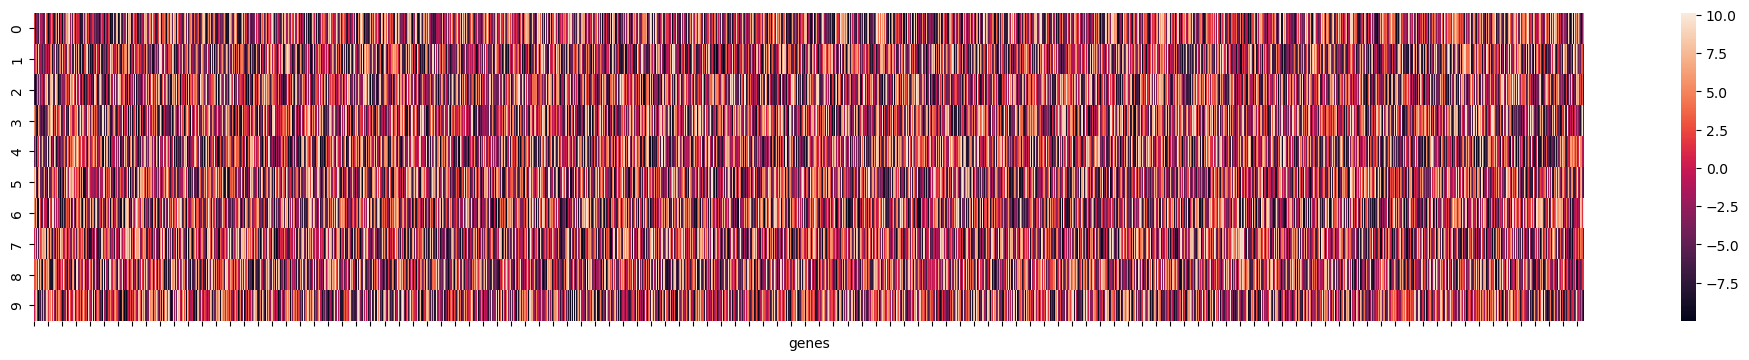

In [8]:
rnaloading = model.module.get_loadings()
plt.figure(figsize=(25,4))
hm = sns.heatmap(rnaloading.T)
hm.set(xticklabels=[]) 
hm.set(xlabel="genes")

[Text(0.5, 14.722222222222216, 'genes')]

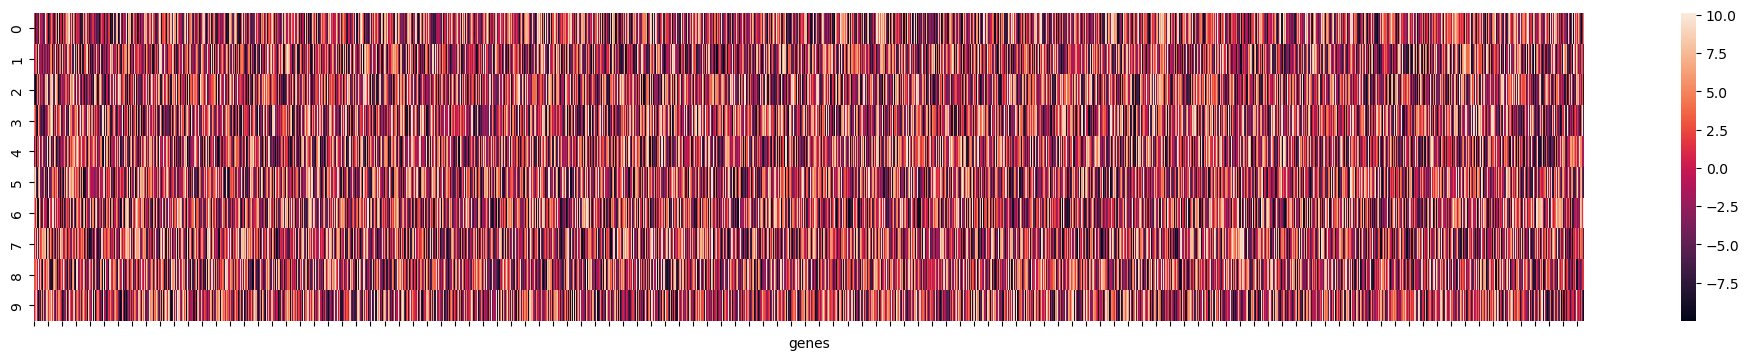

In [10]:
rnaloading2 = np.loadtxt("rnaloadings001.txt")
plt.figure(figsize=(25,4))
hm = sns.heatmap(rnaloading2)
hm.set(xticklabels=[]) 
hm.set(xlabel="genes")

In [11]:
rnaloading2==rnaloading

/tmp/ipykernel_10796/2181995023.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  rnaloading2==rnaloading


False

In [14]:
np.savetxt("rnaloadings001.txt", rnaloading)

In [6]:
# rnaloading = rnaloading.T
# genes_num = rnaloading.shape[1]
# decouple = []
# couple = []
# for i in range(genes_num):
#     couple_latent = rnaloading[:5, i]
#     decouple_latent = rnaloading[5:,i]
#     if np.all(couple_latent >= decouple_latent):
#         couple.append(i)

#     elif np.all(decouple_latent > couple_latent):
#         decouple.append(i)

# print("whole genes :{}, coupled genes : {}, decoupled genes: {}".format(genes_num, len(couple), len(decouple)))          


In [45]:
rnaloading = rnaloading.T
genes_num = rnaloading.shape[1]
type_dict = []

for i in range(genes_num):
    couple_latent = rnaloading[:5, i]
    decouple_latent = rnaloading[5:,i]
    if np.max(couple_latent) >= np.max(decouple_latent) and np.min(couple_latent) >= np.min(decouple_latent) and np.min(couple_latent)>0:
        type_dict.append("coupled")

    elif np.max(decouple_latent) >= np.max(couple_latent) and np.min(decouple_latent) >= np.min(couple_latent) and np.min(decouple_latent)>0:
        type_dict.append("decoupled")
    else:
        type_dict.append("neither")

type_dict = np.array(type_dict)

print("whole genes :{}, coupled genes : {}, decoupled genes: {}, neither {}".format(genes_num, np.count_nonzero(type_dict=="coupled"),  np.count_nonzero(type_dict=="decoupled"), np.count_nonzero(type_dict=="neither")))    

whole genes :14583, coupled genes : 296, decoupled genes: 293, neither 13994


In [39]:
## define the new decouple and coupled genes

def get_coupled_decoupled_score(rnaloading):
    decouple_score = []
    couple_score = []

    for i in range(genes_num):
        couple_latent = rnaloading[:5, i]
        decouple_latent = rnaloading[5:,i]
        couple_score.append(np.mean(couple_latent))
        decouple_score.append(np.mean(decouple_latent))
    return decouple_score,  couple_score



def get_top_decoupled_genes(decouple_score, percentile=0.01):
    return np.argsort(decouple_score)[-int(percentile*len(decouple_score)):]


def get_top_coupled_genes(couple_score, percentile=0.01):
    return np.argsort(couple_score)[-int(percentile*len(couple_score)):]    


In [40]:
decoupled_score, coupled_score = get_coupled_decoupled_score(rnaloading=rnaloading)

top_decoupled_genes_index = get_top_decoupled_genes(decouple_score=decoupled_score)

top_coupled_genes_index = get_top_coupled_genes(couple_score=coupled_score)


In [42]:
top_decoupled_genes_index

array([14422, 10654,  1696,  2476, 10409,  2677,  2637, 10034, 11069,
        8377,  8681,  5518, 13344,   186,  7042,  5688,  5805,  3422,
       12808, 10557, 13072,  5116,  6652, 13738,  4423,  7376,  3489,
       14568, 13851,  5238,  4028,  1644,  4912, 13621, 10872,  7476,
        9849,  6166, 11406,  2003, 10554,  6984,  3741, 11280,  1746,
         970, 12591, 14195,  7554,  9440,  7027, 12769, 14036,  3062,
        9760,  6303,   374,  2924,  8132,  1001,  5975,   411, 11029,
       13554, 13017,  2598,  9964, 13992,  3972,  2569,   281,   624,
         406, 12297,  1190, 11236, 14313, 10477,  2531,  1397,  2858,
       12552, 12023, 13946,  2421, 11631, 11820,  1800,  3206,  4439,
       11716,  3711,  2504, 13714,  2461,  4160,  1402,  5363,  3687,
       13761,  3267,  1323,  7242, 14291,  8151,  1448,  5081, 11343,
        6968,  9271,  7596, 12398, 10701,  7990,  6386,  9662,  5613,
        2988, 11273,  3604,  5608,   757,  6392,  5507,  7803, 11992,
       12461,  8364,

AnnData object with n_obs × n_vars = 3365 × 14583
    obs: 'celltype', 'batch_id', 'modality', 'latent_time', '_scvi_batch', '_scvi_labels', 'latent_decouple', 'latent_couple', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'latent_10', 'test_set', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'model_read_scale', 'softmax_denom'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog', 'types', 'logp'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap', 'X_umap_features', 'latent'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'LITE_logp', 'LITE_prediction', 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
rnaloading = rnaloading.T
genes_num = rnaloading.shape[1]
type_dict = []

for i in range(genes_num):
    couple_latent = rnaloading[:5, i]
    decouple_latent = rnaloading[5:,i]
    if np.mean(couple_latent) >= np.mean(decouple_latent) and np.mean(couple_latent) >0:
        type_dict.append("coupled")

    elif np.mean(decouple_latent) >= np.mean(couple_latent) and np.mean(decouple_latent) >0:
        type_dict.append("decoupled")
    else:
        type_dict.append("neither")

type_dict = np.array(type_dict)

print("whole genes :{}, coupled genes : {}, decoupled genes: {}, neither {}".format(genes_num, np.count_nonzero(type_dict=="coupled"),  np.count_nonzero(type_dict=="decoupled"), np.count_nonzero(type_dict=="neither")))          


whole genes :14583, coupled genes : 5375, decoupled genes: 5490, neither 3718


In [213]:
# rnaloading = rnaloading.T
# genes_num = rnaloading.shape[1]
# decouple_index = []
# couple_index = []
# for i in range(genes_num):
#     couple_latent = rnaloading[:5, i]
#     decouple_latent = rnaloading[5:,i]
#     if np.all(couple_latent > -1) and np.all(decouple_latent<= 0):
#         couple_index.append(i)

#     elif  np.all(decouple_latent > -1) and np.all(couple_latent<=0):
#         decouple_index.append(i)

# print("whole genes :{}, \n coupled genes : {}, \n decoupled genes: {}".format(genes_num, couple_index, decouple_index))       

whole genes :14583, 
 coupled genes : [415, 567, 1841, 2919, 2933, 3027, 3285, 3630, 3970, 4001, 4976, 5533, 5727, 5865, 7171, 8040, 8715, 9132, 10059, 10342, 11122, 11719, 12402, 12468, 13701, 14579], 
 decoupled genes: [326, 2230, 2557, 3705, 4364, 4876, 6853, 8591, 8627, 9170, 9210, 9682, 9849, 10738, 10848, 11601, 12226, 12612, 12712, 12741, 12769, 14185]


In [ ]:
# loadmatrix = loadmatrix.T
# peaks_num = loadmatrix.shape[1]
# pdecouple = []
# pcouple = []
# for i in range(peaks_num):
#     couple_latent = loadmatrix[:5, i]
#     decouple_latent = loadmatrix[5:,i]
#     if np.all(couple_latent >= 0) and np.all(decouple_latent<0):
#         pcouple.append(i)

#     elif  np.all(decouple_latent >= 0) and np.all(couple_latent<0):
#         pdecouple.append(i)

# print("whole genes :{}, coupled peaks : {}, decoupled peaks: {}".format(peaks_num, pcouple, pdecouple))          

In [29]:
# peaks_num = loadmatrix.shape[1]
# ptype_dict = []
# for i in range(peaks_num):
#     couple_latent = loadmatrix[:5, i]
#     decouple_latent = loadmatrix[5:,i]
#     if np.max(couple_latent) >= np.max(decouple_latent) and np.min(couple_latent) >= np.min(decouple_latent) and np.min(couple_latent)>0:
#         ptype_dict.append("coupled")

#     elif np.max(decouple_latent) >= np.max(couple_latent) and np.min(decouple_latent) >= np.min(couple_latent) and np.min(decouple_latent)>0:
#         ptype_dict.append("decoupled")
#     else:
#         ptype_dict.append("neither")

# ptype_dict = np.array(ptype_dict)

# print("whole peaks :{}, coupled peaks : {}, decoupled peaks: {}, neither {}".format(peaks_num, np.count_nonzero(ptype_dict=="coupled"),  np.count_nonzero(ptype_dict=="decoupled"), np.count_nonzero(ptype_dict=="neither")))          


whole peaks :123883, coupled peaks : 25480, decoupled peaks: 42994, neither 55409


In [3]:
atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_mira.h5ad")

In [9]:
rna_data.var["types"] = type_dict
rna_data.var[rna_data.var.types=="coupled"].count()

gene_ids            5375
feature_types       5375
modality            5375
n_cells             5375
highly_variable     5375
means               5375
dispersions         5375
dispersions_norm    5375
exog                5375
endog               5375
types               5375
dtype: int64

In [5]:
rna_data.obs

,celltype,batch_id,modality,latent_time,_scvi_batch,_scvi_labels,latent_decouple,latent_couple,latent_1,latent_2,...,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,model_read_scale,softmax_denom
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired,0.604954,0,0,0.426128,0.978945,-1.762500,1.757364,...,0.035730,0.018085,0.435679,0.071903,0.020078,0.074781,0.000367,0.036394,6.915498,3245.729736
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired,0.281341,0,0,0.086842,0.828030,1.020511,-1.984046,...,0.271384,0.016359,0.001202,0.004536,0.657100,0.003350,0.000142,0.004700,7.536094,2208.164062
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired,0.851495,0,0,-1.055951,-2.345383,0.255288,-2.169485,...,0.002951,0.374780,0.001070,0.006007,0.001719,0.007430,0.001279,0.043208,8.246658,2234.916748
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired,0.982605,0,0,-0.678755,-1.834370,1.508247,0.174381,...,0.003074,0.074553,0.003312,0.012114,0.003180,0.025199,0.001130,0.105735,7.352932,1950.110107
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired,0.549869,0,0,0.122593,-0.642178,-0.765909,-2.346190,...,0.021989,0.351842,0.034497,0.024388,0.012385,0.021237,0.000628,0.018268,7.005153,3075.645508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired,0.454965,0,0,0.412956,-1.799858,0.339506,1.417487,...,0.005820,0.128786,0.029641,0.037600,0.004146,0.008559,0.000731,0.005659,8.261782,3378.617676
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired,0.598991,0,0,0.239816,0.199178,-1.973431,1.644840,...,0.005302,0.026352,0.272781,0.130449,0.004899,0.269730,0.000371,0.056904,7.010578,3228.003174
TTTGTGTTCAATGACC-1_paired,IPC,1,paired,0.291581,0,0,0.911365,1.677551,1.747887,2.361526,...,0.012303,0.006316,0.005637,0.003558,0.126949,0.002514,0.000051,0.002700,6.931353,3536.458252
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired,0.776289,0,0,-0.187027,-2.587236,-0.609144,-0.305569,...,0.001680,0.050006,0.002026,0.007967,0.001137,0.008923,0.000911,0.199967,7.842948,1879.951782


In [48]:
rna_data.var["coupled_score"] = coupled_score
rna_data.var["decouple_score"] = decoupled_score

In [142]:
## matching the latent time of RNA data
rna_data.obs["latent_time"] = adata_mvi.obs["latent_time"]

In [50]:
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
XKR4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False,decoupled,0.000000,-1.844988,0.431689
GM1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443,False,0.124291,0.168296,-0.830691,False,False,decoupled,0.000000,0.709567,4.227605
GM19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683,False,0.228712,0.461415,-0.033439,False,False,coupled,0.000000,1.848573,-3.118394
RP1,ENSMUSG00000025900,Gene Expression,Gene Expression,36,True,0.020071,0.943040,1.276528,True,True,neither,-0.053728,-0.495178,-0.961265
MRPL15,ENSMUSG00000033845,Gene Expression,Gene Expression,971,False,0.319294,0.355616,-0.493027,False,False,coupled,0.000000,6.936676,3.961262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,Gene Expression,695,False,0.239101,0.455474,-0.049597,False,False,coupled,0.000000,3.369150,1.242772
VAMP7,ENSMUSG00000051412,Gene Expression,Gene Expression,755,False,0.239121,0.339640,-0.364654,False,False,coupled,0.000000,6.109159,-7.687541
TMLHE,ENSMUSG00000079834,Gene Expression,Gene Expression,559,True,0.223619,0.611113,0.373723,True,False,neither,0.000000,-3.394443,-2.122128
4933409K07RIK,ENSMUSG00000095552,Gene Expression,Gene Expression,52,False,0.012195,-0.123272,-1.623724,False,False,decoupled,0.000000,-4.515069,0.561215


In [48]:
rna_data.var[(rna_data.var.types!="neither")&(rna_data.var.highly_variable==True)]

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types
ADHFE1,ENSMUSG00000025911,Gene Expression,Gene Expression,132,True,0.053766,0.747508,0.744703,True,True,decoupled
GM28153,ENSMUSG00000099895,Gene Expression,Gene Expression,93,True,0.036703,0.664255,0.518263,True,False,decoupled
ANKRD44,ENSMUSG00000052331,Gene Expression,Gene Expression,1651,True,0.721889,0.760741,0.230803,True,False,decoupled
ZDBF2,ENSMUSG00000027520,Gene Expression,Gene Expression,924,True,0.359834,0.699343,0.382958,True,False,coupled
MARCH4,ENSMUSG00000039372,Gene Expression,Gene Expression,1095,True,0.487692,0.951774,1.026278,True,True,decoupled
...,...,...,...,...,...,...,...,...,...,...,...
DNMBP,ENSMUSG00000025195,Gene Expression,Gene Expression,349,True,0.130664,0.601902,0.348671,True,False,decoupled
SORCS1,ENSMUSG00000043531,Gene Expression,Gene Expression,562,True,0.840381,2.880786,4.086992,True,True,coupled
MSN,ENSMUSG00000031207,Gene Expression,Gene Expression,211,True,0.102765,0.990072,1.404451,True,True,coupled
COL4A6,ENSMUSG00000031273,Gene Expression,Gene Expression,78,True,0.055598,1.506423,2.808871,True,True,coupled


In [32]:
atac_data.var["types"] = ptype_dict
atac_data.var

,chr,start,end,n_cells,types
peak_id,,,,,
1,chr1,3094399,3095523,235,coupled
2,chr1,3113503,3114077,103,neither
3,chr1,3119414,3121804,449,neither
4,chr1,3198296,3198611,46,decoupled
5,chr1,3210204,3210605,52,neither
...,...,...,...,...,...
123879,GL456216.1,37994,39286,266,neither
123880,GL456216.1,40534,41810,139,coupled
123881,GL456216.1,49045,49376,35,neither


In [51]:
## save the data
rna_data.write_h5ad("data/datasets/mouse_brain_rna_mira.h5ad")
# atac_data.write_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")


In [10]:
logp = rna_data.layers['LITE_logp']
logp = np.mean(logp, axis=0)
logp = np.squeeze(np.ravel(logp))
print(logp.shape)


(14583,)


In [11]:
rna_data.var["logp"] = logp
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp
XKR4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False,decoupled,0.000000
GM1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443,False,0.124291,0.168296,-0.830691,False,False,decoupled,0.000000
GM19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683,False,0.228712,0.461415,-0.033439,False,False,coupled,0.000000
RP1,ENSMUSG00000025900,Gene Expression,Gene Expression,36,True,0.020071,0.943040,1.276528,True,True,neither,-0.053728
MRPL15,ENSMUSG00000033845,Gene Expression,Gene Expression,971,False,0.319294,0.355616,-0.493027,False,False,coupled,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,Gene Expression,695,False,0.239101,0.455474,-0.049597,False,False,coupled,0.000000
VAMP7,ENSMUSG00000051412,Gene Expression,Gene Expression,755,False,0.239121,0.339640,-0.364654,False,False,coupled,0.000000
TMLHE,ENSMUSG00000079834,Gene Expression,Gene Expression,559,True,0.223619,0.611113,0.373723,True,False,neither,0.000000
4933409K07RIK,ENSMUSG00000095552,Gene Expression,Gene Expression,52,False,0.012195,-0.123272,-1.623724,False,False,decoupled,0.000000


In [12]:
rna_data.var[rna_data.var.types == "coupled"].count()

gene_ids            5375
feature_types       5375
modality            5375
n_cells             5375
highly_variable     5375
means               5375
dispersions         5375
dispersions_norm    5375
exog                5375
endog               5375
types               5375
logp                5375
dtype: int64

In [13]:
rna_data.var[rna_data.var.types == "decoupled"].count()

gene_ids            5490
feature_types       5490
modality            5490
n_cells             5490
highly_variable     5490
means               5490
dispersions         5490
dispersions_norm    5490
exog                5490
endog               5490
types               5490
logp                5490
dtype: int64

In [52]:
highly_variable = rna_data.var[(rna_data.var.highly_variable ==True) & (rna_data.var.types!="neither")]
highly_variable.head()

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
XKR4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False,decoupled,0.0,-1.844988,0.431689
LYPLA1,ENSMUSG00000025903,Gene Expression,Gene Expression,614,True,0.261086,0.795966,0.876502,True,True,decoupled,0.0,1.137197,3.726424
RGS20,ENSMUSG00000002459,Gene Expression,Gene Expression,731,True,0.767623,2.361085,3.715415,True,True,decoupled,0.0,-1.241130,3.015719
SNTG1,ENSMUSG00000025909,Gene Expression,Gene Expression,1582,True,1.002458,1.756912,1.893129,True,True,decoupled,0.0,-1.009553,3.148777
ADHFE1,ENSMUSG00000025911,Gene Expression,Gene Expression,132,True,0.053766,0.747508,0.744703,True,True,decoupled,0.0,-2.534974,4.901233


In [53]:
# highly_variable = highly_variable.reset_index()

highly_variable = highly_variable.sort_values("logp")
highly_variable.head()

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
SLC35F1,ENSMUSG00000038602,Gene Expression,Gene Expression,2850,True,2.036683,2.154516,0.770299,True,True,decoupled,-2.840467,1.475494,2.593810
FOXP1,ENSMUSG00000030067,Gene Expression,Gene Expression,2725,True,1.897932,2.233712,0.876769,True,True,coupled,-2.744577,2.838679,2.354747
B3GALT1,ENSMUSG00000034780,Gene Expression,Gene Expression,2754,True,1.924093,2.129062,0.736079,True,True,decoupled,-2.706865,0.482578,3.338484
NRP1,ENSMUSG00000025810,Gene Expression,Gene Expression,2195,True,1.874500,2.416924,1.123079,True,True,decoupled,-2.567115,-1.998578,3.240484
KIRREL3,ENSMUSG00000032036,Gene Expression,Gene Expression,1725,True,2.226248,3.502285,2.081258,True,True,decoupled,-2.467119,-1.273269,1.133984


In [92]:
highly_variable["coupled_score"] = highly_variable.coupled_score.abs()
highly_variable["decouple_score"] = highly_variable.decouple_score.abs()


In [93]:
decouple = highly_variable[highly_variable.types=="decoupled"]
couple = highly_variable[highly_variable.types=="coupled"]


In [95]:
top_decouple = highly_variable.sort_values("decouple_score",ascending=False).head(30)
top_couple = highly_variable.sort_values("coupled_score",ascending=False).head(30)

In [94]:
# couple = rna_data.var[(rna_data.var.highly_variable ==True) & (rna_data.var.types=="coupled")]
# couple = couple.sort_values("logp").reset_index()
couple.head(30)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
FOXP1,ENSMUSG00000030067,Gene Expression,Gene Expression,2725,True,1.897932,2.233712,0.876769,True,True,coupled,-2.744577,2.838679,2.354747
LRRTM4,ENSMUSG00000052581,Gene Expression,Gene Expression,1493,True,2.104972,3.385539,2.425276,True,True,coupled,-2.256176,1.372801,1.185988
VCAN,ENSMUSG00000021614,Gene Expression,Gene Expression,1841,True,1.304975,1.978453,1.585729,True,True,coupled,-1.919856,0.714004,2.863972
9130024F11RIK,ENSMUSG00000087022,Gene Expression,Gene Expression,1710,True,1.143001,1.542054,0.897860,True,True,coupled,-1.705929,3.945592,0.360013
SIK3,ENSMUSG00000034135,Gene Expression,Gene Expression,1531,True,0.692542,0.979914,0.708032,True,True,coupled,-1.328065,5.663428,2.150251
DPH6,ENSMUSG00000057147,Gene Expression,Gene Expression,1209,True,0.523724,0.919722,0.944594,True,True,coupled,-1.096885,1.431077,4.626118
RGMA,ENSMUSG00000070509,Gene Expression,Gene Expression,1045,True,0.498445,1.089667,1.377696,True,True,coupled,-0.957620,2.289124,0.955979
ARHGAP20,ENSMUSG00000053199,Gene Expression,Gene Expression,841,True,0.369157,0.945076,1.009207,True,True,coupled,-0.799629,3.641843,1.003701
ITGB3BP,ENSMUSG00000028549,Gene Expression,Gene Expression,795,True,0.332759,0.831543,0.719869,True,True,coupled,-0.765169,1.714660,0.588600
TTYH1,ENSMUSG00000030428,Gene Expression,Gene Expression,669,True,0.373109,1.469939,2.346819,True,True,coupled,-0.634164,1.026914,1.607107


In [83]:
decouple.sort_values("decouple_score", ascending=False).head(50)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
ELP4,ENSMUSG00000027167,Gene Expression,Gene Expression,1551,True,0.675890,0.991384,0.733007,True,True,decoupled,-1.273747,0.986253,7.846490
GM49380,ENSMUSG00000111409,Gene Expression,Gene Expression,40,True,0.015419,0.602909,0.351411,True,False,decoupled,0.000000,0.395480,7.753036
COL4A1,ENSMUSG00000031502,Gene Expression,Gene Expression,345,True,0.226378,2.996886,6.862768,True,True,decoupled,0.000000,0.654349,7.243837
PLD5,ENSMUSG00000055214,Gene Expression,Gene Expression,73,True,0.030073,0.743416,0.733575,True,True,decoupled,0.000000,2.596892,7.237801
EPB41L4B,ENSMUSG00000028434,Gene Expression,Gene Expression,153,True,0.054875,0.630796,0.427260,True,False,decoupled,0.000000,-1.697338,7.001814
P4HA1,ENSMUSG00000019916,Gene Expression,Gene Expression,1024,True,0.391171,0.742744,0.493565,True,False,decoupled,0.000000,-0.335596,6.691987
B3GAT1,ENSMUSG00000045994,Gene Expression,Gene Expression,1267,True,0.620260,1.126249,1.026664,True,True,decoupled,0.000000,-1.256217,6.686965
CCDC141,ENSMUSG00000044033,Gene Expression,Gene Expression,177,True,0.104104,2.117103,4.469854,True,True,decoupled,0.000000,-3.589615,6.686856
CD82,ENSMUSG00000027215,Gene Expression,Gene Expression,79,True,0.026812,0.652261,0.485643,True,False,decoupled,0.000000,3.366694,6.605284
KIF2C,ENSMUSG00000028678,Gene Expression,Gene Expression,137,True,0.074150,1.033154,1.521629,True,True,decoupled,0.000000,-0.004426,6.453577


In [96]:
top_couple.head(30)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
SNX8,ENSMUSG00000029560,Gene Expression,Gene Expression,158,True,0.066791,0.680346,0.562029,True,False,coupled,0.0,8.016870,1.292120
TOP2A,ENSMUSG00000020914,Gene Expression,Gene Expression,440,True,0.674346,2.725963,4.509905,True,True,coupled,0.0,7.715202,0.904842
NEMP1,ENSMUSG00000040195,Gene Expression,Gene Expression,478,True,0.178601,0.669797,0.533338,True,False,decoupled,0.0,7.688653,0.166549
GM15155,ENSMUSG00000055109,Gene Expression,Gene Expression,96,True,0.051634,1.120093,1.758094,True,True,decoupled,0.0,7.610312,3.765868
TANK,ENSMUSG00000064289,Gene Expression,Gene Expression,806,True,0.317087,0.678086,0.328785,True,False,coupled,0.0,7.534791,2.528788
ACVR2A,ENSMUSG00000052155,Gene Expression,Gene Expression,2064,True,0.961082,1.074425,0.560879,True,False,coupled,0.0,7.198705,0.743300
CSF1,ENSMUSG00000014599,Gene Expression,Gene Expression,99,True,0.045669,0.721926,0.675122,True,False,decoupled,0.0,7.067703,1.064201
GM13684,ENSMUSG00000085335,Gene Expression,Gene Expression,75,True,0.032854,0.733291,0.706036,True,True,decoupled,0.0,7.018174,0.724572
TAF4B,ENSMUSG00000054321,Gene Expression,Gene Expression,105,True,0.046454,0.811722,0.919358,True,True,coupled,0.0,6.875579,4.081926
ATP8B1,ENSMUSG00000039529,Gene Expression,Gene Expression,143,True,0.074590,1.210287,2.003412,True,True,coupled,0.0,6.842718,0.619303


In [99]:
top_decouple[top_decouple.n_cells>500]

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
ELP4,ENSMUSG00000027167,Gene Expression,Gene Expression,1551,True,0.675890,0.991384,0.733007,True,True,decoupled,-1.273747,0.986253,7.846490
FABP7,ENSMUSG00000019874,Gene Expression,Gene Expression,1845,True,1.265980,3.297520,3.664895,True,True,coupled,0.000000,2.786027,7.118239
P4HA1,ENSMUSG00000019916,Gene Expression,Gene Expression,1024,True,0.391171,0.742744,0.493565,True,False,decoupled,0.000000,0.335596,6.691987
B3GAT1,ENSMUSG00000045994,Gene Expression,Gene Expression,1267,True,0.620260,1.126249,1.026664,True,True,decoupled,0.000000,1.256217,6.686965
CCDC58,ENSMUSG00000075229,Gene Expression,Gene Expression,966,True,0.378880,0.773477,0.571888,True,False,coupled,0.000000,0.376457,6.630104
CELSR1,ENSMUSG00000016028,Gene Expression,Gene Expression,738,True,0.485395,1.568440,2.597848,True,True,decoupled,0.000000,0.873158,6.451349
OTUD7B,ENSMUSG00000038495,Gene Expression,Gene Expression,1004,True,0.379750,0.639182,0.229639,True,False,decoupled,0.000000,3.529821,6.444204
MARCH4,ENSMUSG00000039372,Gene Expression,Gene Expression,1095,True,0.487692,0.951774,1.026278,True,True,decoupled,0.000000,1.930278,6.318104
PLPPR5,ENSMUSG00000033342,Gene Expression,Gene Expression,899,True,0.432226,1.106375,1.420278,True,True,decoupled,0.000000,2.354557,6.254901
PHKB,ENSMUSG00000036879,Gene Expression,Gene Expression,1219,True,0.588876,1.146686,1.071163,True,True,coupled,0.000000,2.032937,6.154395


In [112]:
rna_data.var.loc["VCAN"]

gene_ids            ENSMUSG00000021614
feature_types          Gene Expression
modality               Gene Expression
n_cells                           1841
highly_variable                   True
means                         1.304975
dispersions                   1.978453
dispersions_norm              1.585729
exog                              True
endog                             True
types                          coupled
logp                         -1.919856
coupled_score                 0.714004
decouple_score               -2.863972
Name: VCAN, dtype: object

In [77]:
rna_data.var.sort_values("decouple_score", ascending=False).sort_values("logp", ascending=False).head(30)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp,coupled_score,decouple_score
MCFD2,ENSMUSG00000024150,Gene Expression,Gene Expression,315,False,0.092301,0.225188,-0.675949,False,False,decoupled,0.0,-2.442065,8.532846
NOSIP,ENSMUSG00000003421,Gene Expression,Gene Expression,510,False,0.162967,0.327999,-0.396316,False,False,coupled,0.0,2.248032,-1.135694
SEPT6,ENSMUSG00000050379,Gene Expression,Gene Expression,1084,False,0.362051,0.390212,-0.404861,False,False,neither,0.0,-0.311154,-1.125003
GGH,ENSMUSG00000073987,Gene Expression,Gene Expression,533,False,0.185869,0.540618,0.181984,False,False,neither,0.0,-0.155695,-1.125230
UTP23,ENSMUSG00000022313,Gene Expression,Gene Expression,359,False,0.109163,0.249173,-0.610713,False,False,coupled,0.0,3.780539,-1.125600
DHX15,ENSMUSG00000029169,Gene Expression,Gene Expression,2157,False,0.788653,0.372435,-0.614700,False,False,neither,0.0,-1.824607,-1.125823
DMAC1,ENSMUSG00000028398,Gene Expression,Gene Expression,840,False,0.266089,0.271984,-0.548671,False,False,neither,0.0,-0.102270,-1.125978
B430010I23RIK,ENSMUSG00000084960,Gene Expression,Gene Expression,564,True,0.212788,0.620035,0.397991,True,False,coupled,0.0,1.768841,-1.125990
SEC24C,ENSMUSG00000039367,Gene Expression,Gene Expression,778,False,0.261763,0.479974,0.017039,False,False,coupled,0.0,1.545430,-1.126286
IL1RAPL2,ENSMUSG00000059203,Gene Expression,Gene Expression,221,True,0.455218,3.606872,7.792783,True,True,neither,0.0,-4.777184,-1.126829


In [19]:
rna_data.var[rna_data.var.index=="TLE4"]
# tle = rna_data.var.reset_index().loc[rna_data.var.index=="TLE4"]
# tle.index

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp
TLE4,ENSMUSG00000024642,Gene Expression,Gene Expression,1534,True,1.493037,2.843711,2.210268,True,True,decoupled,-1.756821


In [20]:
rna_data.var[rna_data.var.index=="EPHA3"]


,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp
EPHA3,ENSMUSG00000052504,Gene Expression,Gene Expression,2376,True,2.358191,2.842184,1.227508,True,True,coupled,0.0


In [21]:
rna_data.var[rna_data.var.index=="SIK3"]


,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp
SIK3,ENSMUSG00000034135,Gene Expression,Gene Expression,1531,True,0.692542,0.979914,0.708032,True,True,coupled,-1.328065


In [26]:
rna_data.var[rna_data.var.index=="DPH6"]


,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp
DPH6,ENSMUSG00000057147,Gene Expression,Gene Expression,1209,True,0.523724,0.919722,0.944594,True,True,coupled,-1.096885


In [27]:
rna_data.var[rna_data.var.index=="GM29260"]


,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types,logp
GM29260,ENSMUSG00000100832,Gene Expression,Gene Expression,1460,True,2.011021,3.621005,2.741835,True,True,decoupled,-1.799001


In [22]:
tle = rna_data.var.reset_index().loc[rna_data.var.index=="SIK3"]
tle.index

Int64Index([7364], dtype='int64')

In [24]:
tle = rna_data.var.reset_index().loc[rna_data.var.index=="DPH6"]
tle.index

Int64Index([1478], dtype='int64')

In [29]:
tle = rna_data.var.reset_index().loc[rna_data.var.index=="GM29260"]
tle.index

Int64Index([139], dtype='int64')

In [113]:
tle = rna_data.var.reset_index().loc[rna_data.var.index=="VCAN"]
tle.index

Int64Index([10743], dtype='int64')

[Text(0.5, 23.52222222222222, 'genes')]

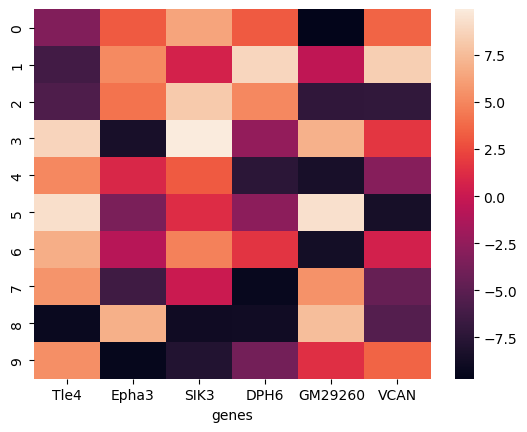

In [12]:
rnaloading = rnaloading.T
decouple = rnaloading[:, [13816, 12337, 7364, 1478, 139, 10743]]
hm = sns.heatmap(decouple)
hm.set(xticklabels=["Tle4", "Epha3", 'SIK3', "DPH6", "GM29260", "VCAN"]) 
hm.set(xlabel="genes")

[Text(0.5, 23.52222222222222, 'genes')]

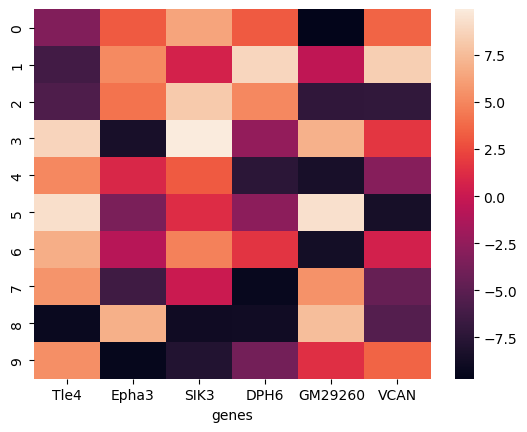

In [14]:
rnaloading2 = rnaloading2.T
decouple = rnaloading2[:, [13816, 12337, 7364, 1478, 139, 10743]]
hm = sns.heatmap(decouple)
hm.set(xticklabels=["Tle4", "Epha3", 'SIK3', "DPH6", "GM29260", "VCAN"]) 
hm.set(xlabel="genes")

In [15]:
absdecouple = decouple
for i in range(decouple.shape[1]):
    coup = np.mean(np.abs(absdecouple[:5, i]), axis=0)
    deco = np.mean(np.abs(absdecouple[5:, i]), axis=0)
    print("couple: {}, decouple:{}".format(coup, deco))

couple: 5.812812423706054, decouple:7.2536357879638675
couple: 4.359103369712829, decouple:5.426713764667511
couple: 5.661095905303955, decouple:4.559632121026516
couple: 5.361336517333984, decouple:5.267767691612244
couple: 6.556111192703247, decouple:6.5015455961227415
couple: 4.768805527687073, decouple:4.4888124704360965


In [48]:
temp = rna_data.var.reset_index()
decouple_row_nums = temp.loc[(temp.types == 'decoupled') & (temp.highly_variable==True)].index
couple_row_nums = temp.loc[(temp.types == 'coupled') & (temp.highly_variable==True)].index


In [49]:
liklihood = rna_data.layers['LITE_logp']
liklihood_coupled = liklihood[:, couple_row_nums]
liklihood_decoupled = liklihood[:, decouple_row_nums]


In [50]:
liklihood_coupled = np.mean(liklihood_coupled, axis=0)
liklihood_decoupled = np.mean(liklihood_decoupled, axis=0)

In [129]:
rna_data

AnnData object with n_obs × n_vars = 3365 × 14583
    obs: 'celltype', 'batch_id', 'modality', 'latent_time', '_scvi_batch', '_scvi_labels', 'latent_decouple', 'latent_couple', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'latent_10', 'test_set', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'model_read_scale', 'softmax_denom'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog', 'types', 'logp'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap', 'X_umap_features', 'latent'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'LITE_logp', 'LITE_prediction', 'counts'
    obsp: 'connectivities', 'distances'